# Document Classifier

In [ ]:
!pip install torchvision

In [1]:
data_dir = "/home/ganeshaa/personal/hackathon/Final/OCR_code/BankData1"
model_path  = "/home/ganeshaa/personal/hackathon/Final/OCR_code/model/doc_classifier_pharmacy_resnet152_100epchs_public_data-wo-id_cards_v4_256_256.pth"

In [2]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torchvision import transforms
plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

#TODO: get the mean and the standard deviation dinamically from the image
splitted_datasets = ['train', 'val', 'test']
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in splitted_datasets}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in splitted_datasets}
dataset_sizes = {x: len(image_datasets[x]) for x in  dataloaders}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
image_datasets['train'][0]

(tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 0.8104,  0.8104,  0.8104,  ...,  0.8104,  0.8104,  0.9988],
          [-1.6213, -1.6213, -1.6213,  ..., -1.6213, -1.6213, -1.0733],
          [-1.3473, -1.3473, -1.3473,  ..., -1.3473, -1.3473, -0.8335]],
 
         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 1.4132,  1.4132,  1.4132,  ...,  1.4132,  1.4132,  1.5532],
          [-0.3025, -0.3025, -0.3025,  ..., -0.3025, -0.3025,  0.0826],
          [-0.1099, -0.1099, -0.1099,  ..., -0.1099, -0.1099,  0.2577]],
 
         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400,  2.6400,

In [5]:
device

device(type='cuda', index=0)

In [6]:
dataset_sizes

{'train': 539, 'val': 81, 'test': 81}

In [7]:
image_datasets['train'].classes

['AccountOpeningForms',
 'AccountStatements',
 'Adhaar',
 'Agreements',
 'Applicationforms',
 'Certificates',
 'ConfidentialReports',
 'CustomerRequestForms',
 'PAN',
 'Reports']

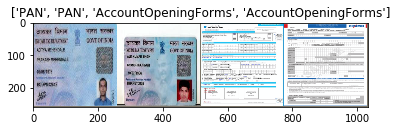

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    #print(inp)
    #print("-1"*10)
    
    inp = inp.numpy().transpose((1, 2, 0))
    #print(inp)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    #print("-2"*10)
    #print(inp)
    inp = np.clip(inp, 0, 1)
    #print("-3"*10)
    #print(inp)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_ft = models.resnet152(pretrained=True)
#model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft.fc = nn.Linear(num_ftrs, len(class_names))
#model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized  # change to ADAM
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training and saving the model

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)
torch.save(model_ft, model_path)

Epoch 0/99
----------
train Loss: 1.9534 Acc: 0.3525
val Loss: 2.1361 Acc: 0.2346

Epoch 1/99
----------
train Loss: 1.6268 Acc: 0.4601
val Loss: 2.5094 Acc: 0.2840

Epoch 2/99
----------
train Loss: 1.4181 Acc: 0.5065
val Loss: 1.8658 Acc: 0.3827

Epoch 3/99
----------
train Loss: 1.4089 Acc: 0.5195
val Loss: 1.9519 Acc: 0.3210

Epoch 4/99
----------
train Loss: 1.3797 Acc: 0.5288
val Loss: 2.2795 Acc: 0.2593

Epoch 5/99
----------
train Loss: 1.2904 Acc: 0.5547
val Loss: 2.0989 Acc: 0.3580

Epoch 6/99
----------
train Loss: 1.2477 Acc: 0.5714
val Loss: 2.1339 Acc: 0.3210

Epoch 7/99
----------
train Loss: 1.1724 Acc: 0.6178
val Loss: 1.6950 Acc: 0.3210

Epoch 8/99
----------
train Loss: 1.0732 Acc: 0.6141
val Loss: 1.6213 Acc: 0.4444

Epoch 9/99
----------
train Loss: 1.0211 Acc: 0.6568
val Loss: 1.5725 Acc: 0.4444

Epoch 10/99
----------
train Loss: 0.9810 Acc: 0.6679
val Loss: 1.6517 Acc: 0.4815

Epoch 11/99
----------
train Loss: 0.9470 Acc: 0.6623
val Loss: 1.6976 Acc: 0.4691

Ep

train Loss: 0.7111 Acc: 0.7570
val Loss: 1.5468 Acc: 0.5556

Epoch 99/99
----------
train Loss: 0.6948 Acc: 0.7699
val Loss: 1.5568 Acc: 0.5432

Training complete in 53m 24s
Best val Acc: 0.555556


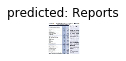

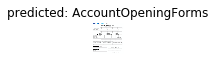

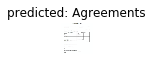

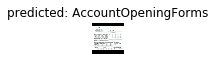

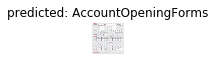

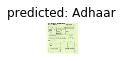

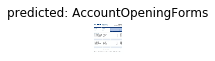

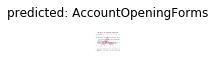

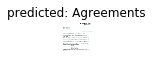

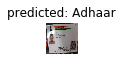

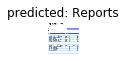

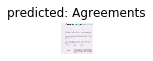

In [13]:
# if you want to visualize some results
visualize_model(model_ft, 12)

# loading the model

In [14]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torchvision import transforms
plt.ion()   # interactive mode
model_after_loading = torch.load(model_path, map_location=torch.device('cpu'))

In [15]:
#if torch.cuda.is_available():
#    model_after_loading.cuda()
model_after_loading

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

['AccountOpeningForms', 'AccountStatements', 'Adhaar', 'Agreements', 'Applicationforms', 'Certificates', 'ConfidentialReports', 'CustomerRequestForms', 'PAN', 'Reports']


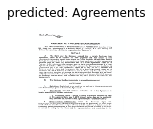

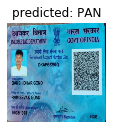

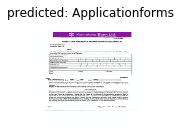

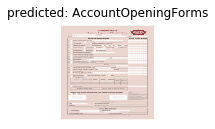

In [16]:
inputs, labels = list(dataloaders['val'])[0]
inputs = inputs.to('cpu')
outputs = model_after_loading(inputs)
_, preds = torch.max(outputs,1)
images_so_far = 0
num_images = inputs.size()[0]
print(class_names)
for j in range(inputs.size()[0]):
    images_so_far += 1
    ax = plt.subplot(num_images//2, 2, images_so_far)
    ax.axis('off')
    ax.set_title('predicted: {}'.format(class_names[preds[j]]))
    imshow(inputs.cpu().data[j])

# Testing one  simple image

In [17]:
from torchvision import datasets, models, transforms
#import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import torch


def predict_single_image(input_path, model_after_loading):
    import time
    start = time.time()
    #input_path = "/home/jose/Desktop/AI-Beta-Team/stories/SmartExtract/quality_model/monochrome_dataset/val/medium_quality/TO_eaton1.jpg"
    
    
    data_transforms = transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = Image.open(input_path)

    #print(type(img))
    #print(img.size)
    #print(len(img))
    # img = img.astype(float)
    # img = img.float()

    img_tensor = data_transforms(img)
    #print(img_tensor.shape)
    input_batch = img_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    input_batch = input_batch.to('cpu')
    outputs = model_after_loading(input_batch)
    probs, preds = torch.max(torch.nn.functional.softmax(outputs, dim=1), dim=1)
    end = time.time()
    
    print(class_names[preds])
    return img


In [19]:
# to predict documents
dir_path = "/home/ganeshaa/personal/hackathon/test_docs"
for im_name in os.listdir(dir_path):
    try:
        print("*******************************")
        print(im_name)
        predict_single_image(os.path.join(dir_path,im_name),model_after_loading)
    except Exception as e:
        print(e)
        
        

*******************************
axisbank-nw-simg-2.jpg
Reports
*******************************
banner.jpg
PAN
*******************************
73403038.png
output with shape [1, 256, 256] doesn't match the broadcast shape [3, 256, 256]
*******************************
375f632fa99c943c5f5299d34d91b8a6.png
The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0
*******************************
b4047be5f6a409a7ac20777d25d5a058 (copy).jpg
Adhaar
*******************************
lar11ge.png
Input tensor should be a float tensor. Got torch.int32.
*******************************
qwer2.png
output with shape [1, 256, 256] doesn't match the broadcast shape [3, 256, 256]
*******************************
images12 (copy).jpeg
PAN
*******************************
Bank-Salary-Loan-Application-Form-1.jpg
AccountOpeningForms
*******************************
imag1e.png
Reports
*******************************
confidential-report-for-credit-union-officials-department-of-banking-

# Getting the metrics

In [20]:
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [21]:

def get_predictions(model, dataloaders):
    images = []
    y_true_list = []
    y_pred_list = []
    #images_names = []

    
    with torch.no_grad():
        for i, (inputs, y) in enumerate(dataloaders['val']):
            inputs = inputs.to('cpu')
            y = y.to('cpu')

            outputs = model_after_loading(inputs)
            _, preds = torch.max(outputs, 1)
            
            #sample_fname, _ = dataloaders['val'].dataset.samples[i]
            #images_names.append(sample_fname)
            images.append(inputs.cpu())
            y_true_list.append(y.cpu())
            y_pred_list.append(preds.cpu())
    images = torch.cat(images, dim = 0)
    labels = torch.cat(y_true_list, dim = 0)
    probs = torch.cat(y_pred_list, dim = 0)

    return images, labels, probs#, images_names

In [22]:

def plot_confusion_matrix(labels, pred_labels, classes):
    plt.rcParams.update({'font.size': 70})
    fig = plt.figure(figsize = (50, 50));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    #fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

In [23]:
images, y_true, y_pred  = get_predictions(model_after_loading, dataloaders) #, images_names

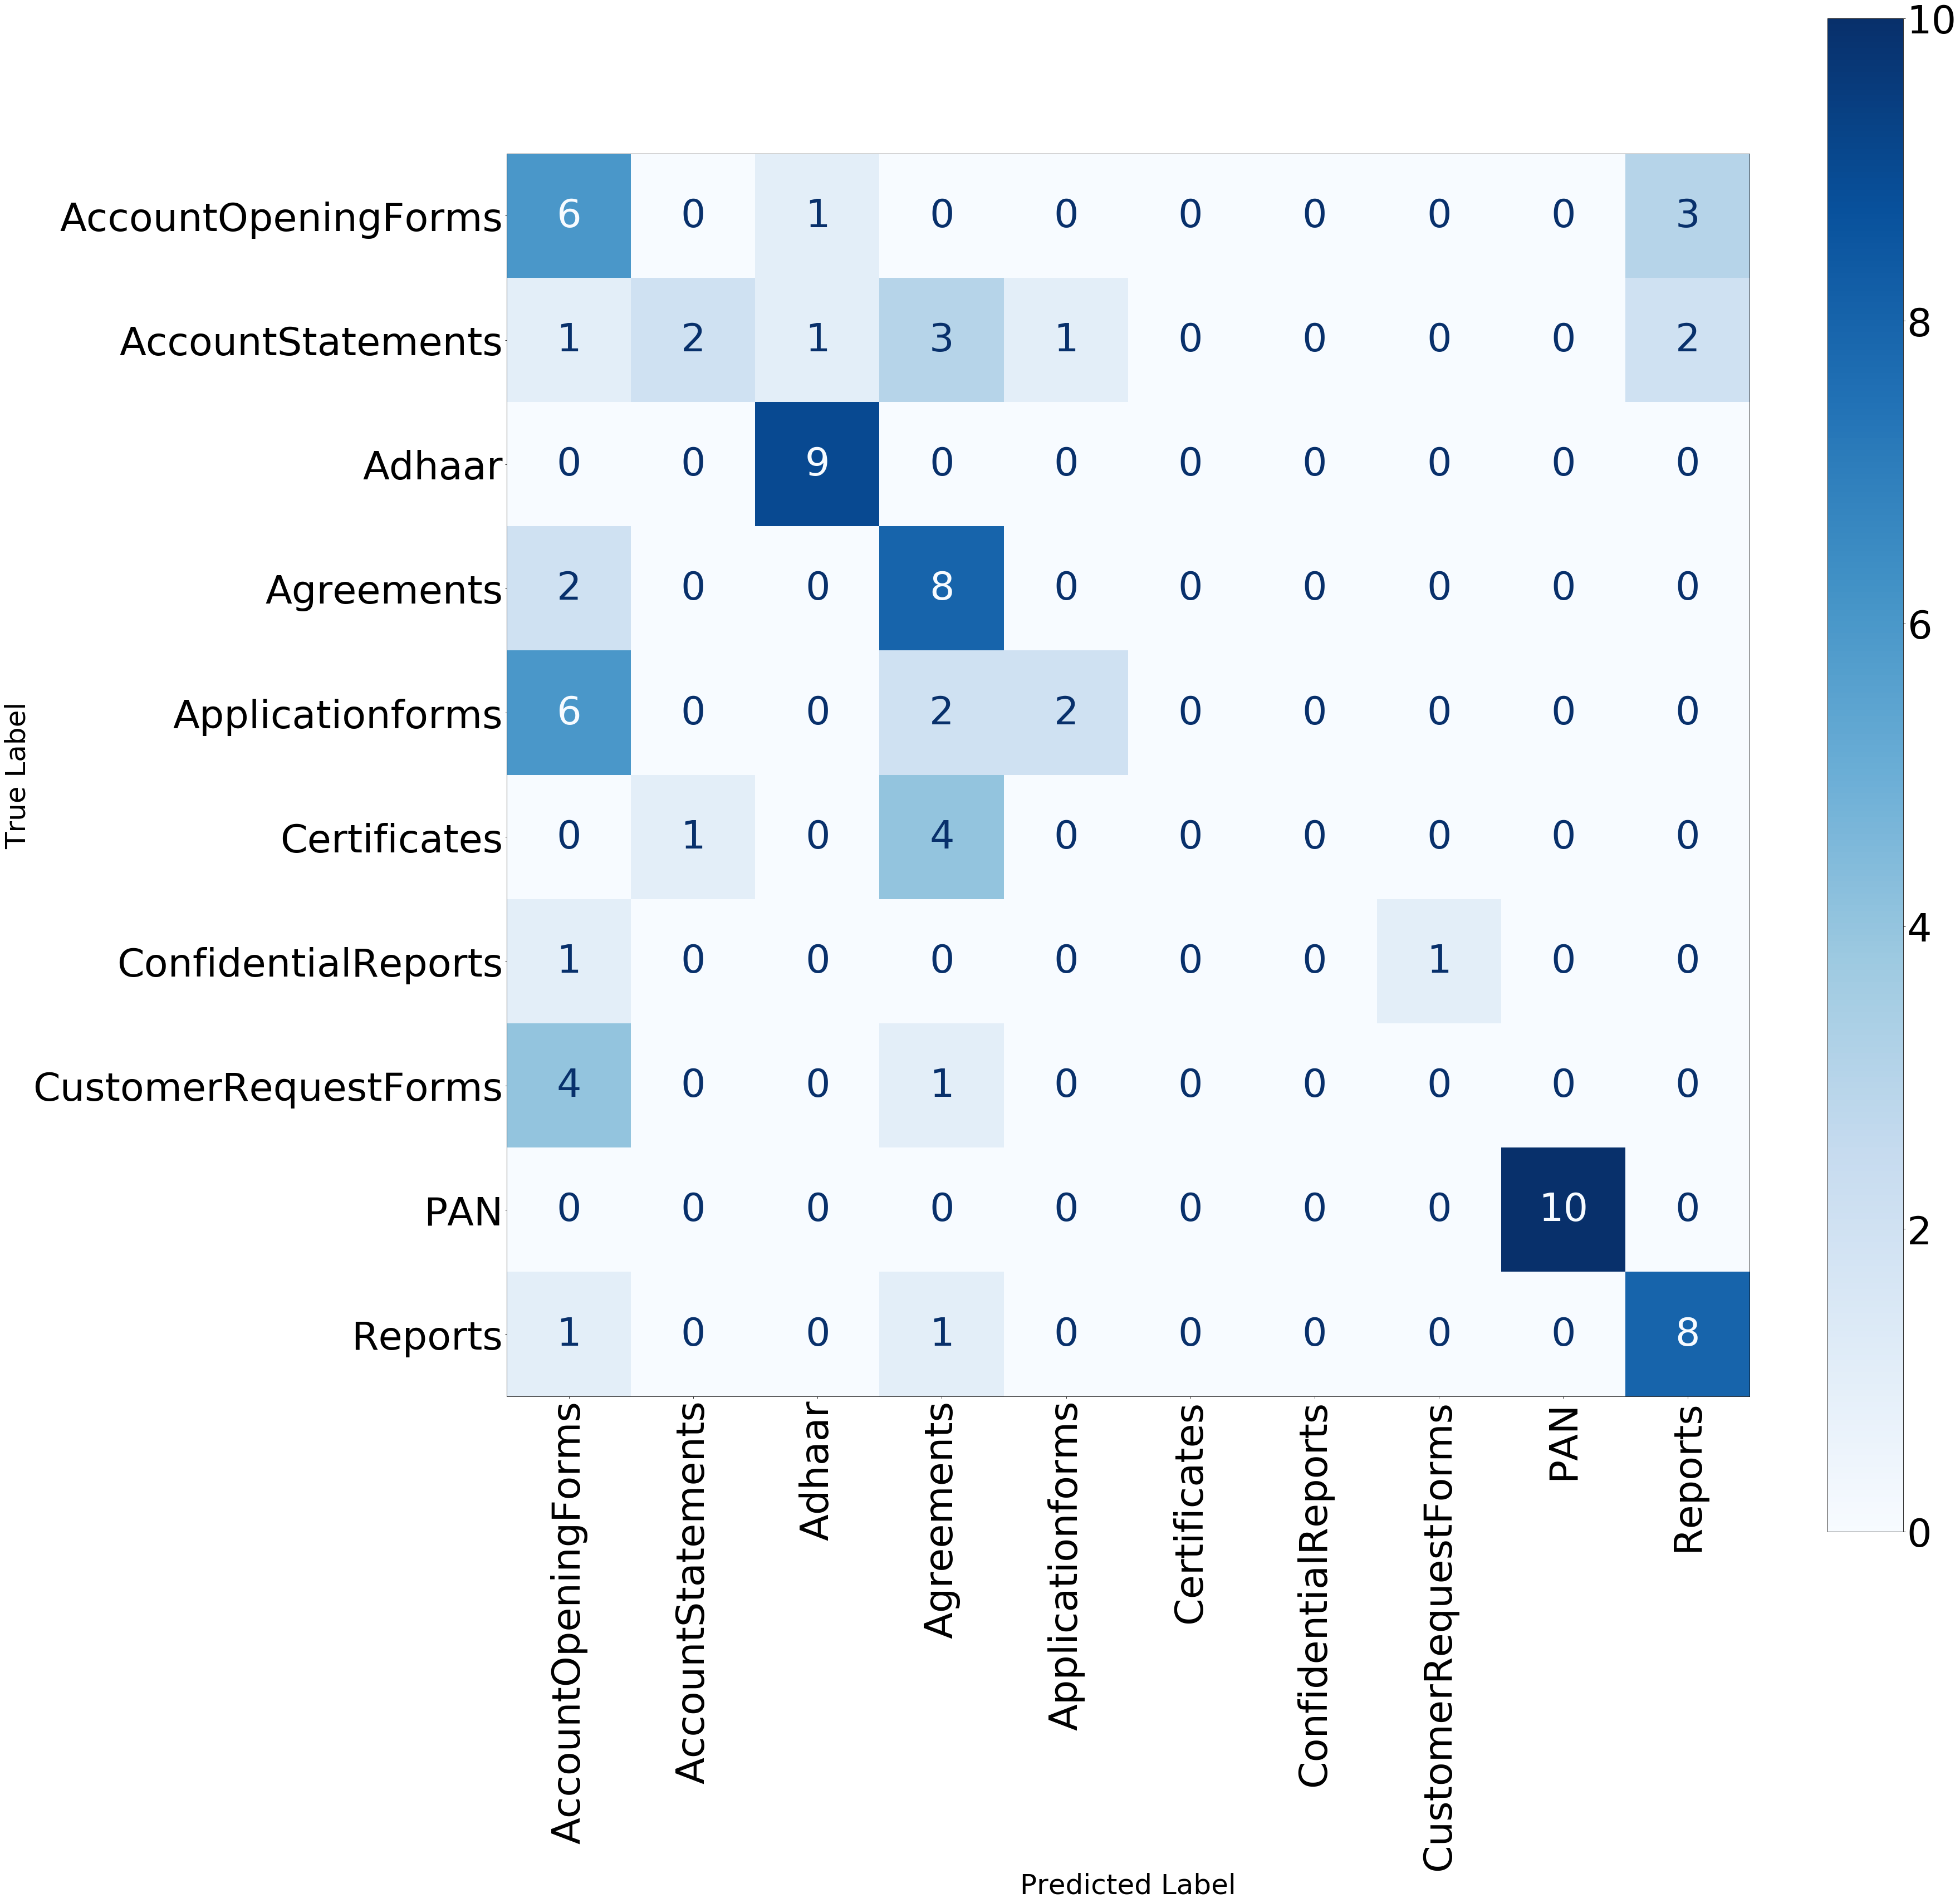

In [24]:
plot_confusion_matrix(y_true, y_pred, class_names)

In [25]:
classification_reports = classification_report(y_true, y_pred)

/home/ganeshaa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
class_names

['AccountOpeningForms',
 'AccountStatements',
 'Adhaar',
 'Agreements',
 'Applicationforms',
 'Certificates',
 'ConfidentialReports',
 'CustomerRequestForms',
 'PAN',
 'Reports']

In [27]:
print(classification_reports)

              precision    recall  f1-score   support

           0       0.29      0.60      0.39        10
           1       0.67      0.20      0.31        10
           2       0.82      1.00      0.90         9
           3       0.42      0.80      0.55        10
           4       0.67      0.20      0.31        10
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         5
           8       1.00      1.00      1.00        10
           9       0.62      0.80      0.70        10

    accuracy                           0.56        81
   macro avg       0.45      0.46      0.41        81
weighted avg       0.54      0.56      0.50        81

